In [27]:
import json
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


In [29]:
# 自定义数据集类
class FashionDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.images = [data['image'] for data in dataset]
        self.labels = [data['label'] for data in dataset]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [31]:
# 定义CNN模型
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # 展平
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [33]:
# 训练模型函数（添加早停法）
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # 用于记录训练和验证的损失和准确率
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # 早停参数
    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # 每个 epoch 有两个阶段：训练和验证
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
                data_loader = train_loader
            else:
                model.eval()   # 设置模型为评估模式
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # 遍历数据
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 训练阶段反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计损失和准确率
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # 计算 epoch 的损失和准确率
            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 记录损失和准确率
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

                # 早停机制
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    early_stopping_counter = 0
                    best_model_wts = model.state_dict()
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        print(f'早停触发，提前停止训练。')
                        # 加载最佳模型权重
                        model.load_state_dict(best_model_wts)
                        # 绘制损失和准确率的折线图
                        plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
                        return model

        print()  # 换行

    print(f'Best val Acc: {max(val_accuracies):.4f}')
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)

    # 绘制损失和准确率的折线图
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

    return model


In [35]:
# 测试模型函数
def test_model(model, test_loader, device):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    total = len(test_loader.dataset)
    acc = running_corrects.double() / total
    print(f'Test Accuracy: {acc:.4f}')


In [37]:
# 绘制训练曲线的函数
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='train loss')
    plt.plot(epochs, val_losses, 'ro-', label='val loss')
    plt.title('train and val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='train acc')
    plt.plot(epochs, val_accuracies, 'ro-', label='val acc')
    plt.title('train and val acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [39]:
# 评估模型函数（在混淆矩阵中添加数字）
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("分类报告：")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('混淆矩阵')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # 在混淆矩阵中添加数字
    thresh = cm.max() / 2.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('true标签')
    plt.xlabel('predict标签')
    plt.tight_layout()
    plt.show()


In [41]:
# 预测函数
def predict(model, image_path, device, data_transforms, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = data_transforms(image).unsqueeze(0)  # 增加 batch 维度
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    predicted_class = class_names[preds.item()]
    return predicted_class


类别名称和对应的编码：
0: accessories
1: bags
2: clothing
3: shoes
Epoch 1/50
----------
train Loss: 1.4783 Acc: 0.5784
val Loss: 0.7293 Acc: 0.8015

Epoch 2/50
----------
train Loss: 0.5230 Acc: 0.8186
val Loss: 0.4172 Acc: 0.8529

Epoch 3/50
----------
train Loss: 0.3553 Acc: 0.8750
val Loss: 0.2658 Acc: 0.9412

Epoch 4/50
----------
train Loss: 0.2138 Acc: 0.9142
val Loss: 0.1662 Acc: 0.9485

Epoch 5/50
----------
train Loss: 0.1291 Acc: 0.9534
val Loss: 0.1584 Acc: 0.9485

Epoch 6/50
----------
train Loss: 0.1007 Acc: 0.9534
val Loss: 0.2102 Acc: 0.9412

Epoch 7/50
----------
train Loss: 0.0969 Acc: 0.9657
val Loss: 0.1423 Acc: 0.9706

Epoch 8/50
----------
train Loss: 0.0677 Acc: 0.9730
val Loss: 0.1438 Acc: 0.9632

Epoch 9/50
----------
train Loss: 0.0666 Acc: 0.9730
val Loss: 0.1246 Acc: 0.9632

Epoch 10/50
----------
train Loss: 0.0351 Acc: 0.9902
val Loss: 0.2003 Acc: 0.9412

Epoch 11/50
----------
train Loss: 0.0437 Acc: 0.9828
val Loss: 0.1875 Acc: 0.9559

Epoch 12/50
----------
train 

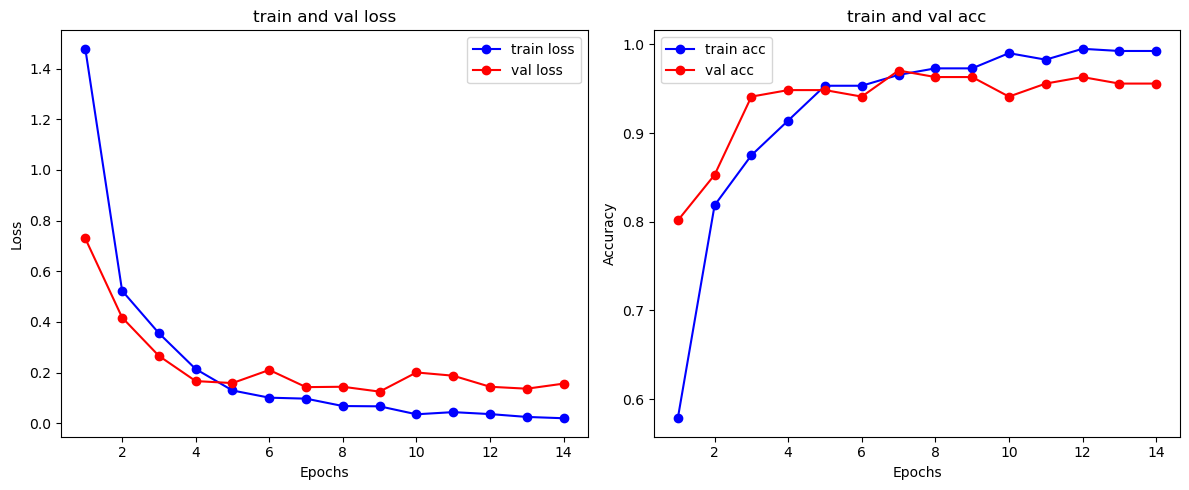

Test Accuracy: 0.9485
分类报告：
              precision    recall  f1-score   support

 accessories       0.75      0.90      0.82        10
        bags       1.00      0.86      0.93        29
    clothing       0.96      0.97      0.96        66
       shoes       0.97      1.00      0.98        31

    accuracy                           0.95       136
   macro avg       0.92      0.93      0.92       136
weighted avg       0.95      0.95      0.95       136



/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83059/784930743.py:38: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83059/784930743.py:38: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83059/784930743.py:38: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83059/784930743.py:38: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_83059/784930743.py:38: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from current font.
  plt.tight_layout()
/var/folders/87/xplw0rd92vxb56h8bts0kjkr0000gn/T/ipykernel_8

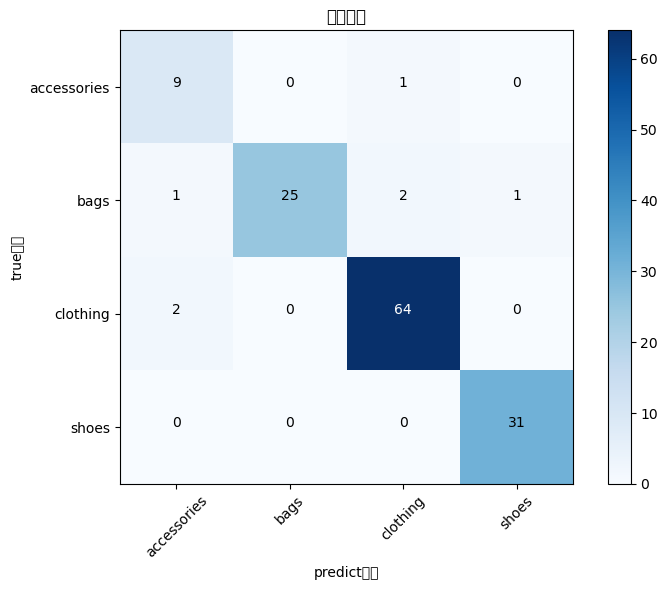

In [ ]:
# 主函数
def main():
    # 加载 JSON 文件
    with open('./【AiDLab】A100/LAT/label/LAT.json', 'r') as f:
        data = json.load(f)

    all_items = []

    for entry in data:
        all_items.extend(entry['question'])
        all_items.extend(entry['answers'])

    items = []
    for item in all_items:
        category, id_ = item.split('_')
        items.append({'category': category, 'id': id_})

    unique_items = { (item['category'], item['id']) for item in items }
    unique_items = [ {'category': cat, 'id': id_} for cat, id_ in unique_items ]

    category_mapping = {
        'Shoes': 'shoes',
        'Top': 'clothing',
        'Pants': 'clothing',
        'Skirt': 'clothing',
        'Dress': 'clothing',
        'Outwear': 'clothing',
        'Earing': 'accessories',
        'Bracelet': 'accessories',
        'Watches': 'accessories',
        'Hat': 'accessories',
        'Neckline': 'accessories',
        'Sunglasses': 'accessories',
        'Bags': 'bags'
    }

    data_dir = './【AiDLab】A100/LAT/image'  # 确保路径正确
    dataset = []

    for item in unique_items:
        category = item['category']
        id_ = item['id']
        label = category_mapping.get(category)
        if label is None:
            continue

        image_path = os.path.join(data_dir, f"{id_}.jpg")
        if not os.path.exists(image_path):
            print(f"图像文件不存在：{image_path}")
            continue

        image = Image.open(image_path).convert('RGB')
        dataset.append({'image': image, 'label': label})

    labels = [data['label'] for data in dataset]
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    for idx, data_item in enumerate(dataset):
        data_item['label'] = encoded_labels[idx]

    class_names = label_encoder.classes_
    print("类别名称和对应的编码：")
    for idx, class_name in enumerate(class_names):
        print(f"{idx}: {class_name}")

    # 定义数据转换
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # 创建数据集实例
    full_dataset = FashionDataset(dataset, transform=data_transforms)

    train_size = int(0.6 * len(full_dataset))
    val_size = int(0.2 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    batch_size = 32
    num_workers = 0  # 或者根据您的系统配置调整
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    num_classes = len(class_names)
    model = SimpleCNN(num_classes=num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 训练模型并打印每个 epoch 的训练准确率
    model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)
    # 测试模型
    test_model(model, test_loader, device)
    # 评估模型
    evaluate_model(model, test_loader, device, class_names)

    # 问答环节：允许用户输入图像路径，模型进行预测
    while True:
        image_path = input("请输入要预测的图像路径（输入 'exit' 退出）：")
        if image_path.lower() == 'exit':
            break
        if not os.path.exists(image_path):
            print("图像文件不存在，请重新输入。")
            continue
        predicted_class = predict(model, image_path, device, data_transforms, class_names)
        print(f"预测类别：{predicted_class}")

# 运行主函数
if __name__ == '__main__':
    main()
